This notebook will be used to create the plots that will do daily comparisons of the model to ONC VENUS nodes.

In [1]:
import os
import glob
import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex
import datetime
import pandas as pd
import seaborn as sns
import scipy.io as sio

import netCDF4 as nc
from salishsea_tools import (viz_tools, tidetools, nc_tools)
from salishsea_tools.nowcast import (research_VENUS, analyze, figures)

%matplotlib inline

In [2]:
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '15', 'color': 'white',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '13', 'color': 'white'}

In [3]:
yesterday = datetime.datetime(2015, 7, 29, 0, 45, 0)

#Prepare velocities

In [4]:
def load_vel(day, station, source, deprange):
    """prepares the model and observational velocities for plotting. The day is the day as a datetime object.
   The station is either Central or East, the source is either model or observational and the depthrange is the
   range of depths in m overwhich you want to have the velocities"""
    if source == 'model':
        today = day.strftime('%d%b%y').lower()

        if station =='Central':
            fil='/data/dlatorne/MEOPAR/SalishSea/nowcast/{}/VENUS_central_gridded.nc'.format(today)
        else:
            fil='/data/dlatorne/MEOPAR/SalishSea/nowcast/{}/VENUS_east_gridded.nc'.format(today)
        filet=glob.glob('/data/dlatorne/MEOPAR/SalishSea/nowcast/{}/SalishSea_1h_*_grid_T.nc'.format(today))[0]

        grid=nc.Dataset(fil)
        grid_t=nc.Dataset(filet)
        
        #Set up model nowcast variables
        dep = grid.variables['depthv']  
        jm = np.where(np.logical_and(dep[:] > deprange[0], dep[:] < deprange[1]))
        dep = dep[jm[0]] 

        u_u = grid.variables['vozocrtx'][:,jm[0],:]
        v_v = grid.variables['vomecrty'][:,jm[0],:]
        u_E, v_N = research_VENUS.unstag_rot(u_u, v_v)
        u = u_E[..., 0, 0]
        v = v_N[..., 0, 0]      
    else:
        if station =='Central':
            fil = sio.loadmat('/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/Nodes/ADCPcentral.mat')
        else:
            fil = sio.loadmat('/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/Nodes/ADCPeast.mat')

        #Set up observations files adn variables
        timemat = fil['mtime']
        #find index
        for mattime, count in zip(timemat[0], np.arange(len(timemat[0]))):
            time = datetime.datetime.fromordinal(int(mattime)) + datetime.timedelta(days=mattime%1) - datetime.timedelta(days = 366)
            if time == day:
                thetime = time
                ind = count-1
                
        oneday = 48       
        dep = fil['chartdepth'][:][0]
        j = np.where(np.logical_and(dep[:] > deprange[0], dep[:] < deprange[1]))
        dep = dep[j[0]]

        u = fil['utrue'][:][j[0], ind:ind+oneday]/100
        v = fil['vtrue'][:][j[0], ind:ind+oneday]/100

    return u, v, dep


In [5]:
def plotADCP(day, station, profile):
    
    u_E, v_N, dep_t = load_vel(day, station, 'model', profile)
    u, v, dep = load_vel(day, station, 'observational', profile)
    
    #Begin figure
    fig, ([axmu, axmv], [axou, axov]) = plt.subplots(2, 2, figsize=(20,10), sharex=True)
    fig.patch.set_facecolor('#2B3E50')

    max_v = np.nanmax(abs(v))
    max_u = np.nanmax(abs(u))
    max_speed = np.amax([max_v, max_u])
    vmax = max_speed
    vmin = -vmax
    step = 0.05

    cmap = plt.get_cmap('jet')
    dep_s = research_VENUS.SITES['VENUS'][station]['depth']
    
    increment = [0.25, 0.5, 0.25, 0.5]
    velocities = [u_E.transpose(), u, v_N.transpose(), v]
    axes = [axmu, axmv,axou, axov]
    depths = [dep_t, dep, dep_t, dep]
    names = ['Model', 'Observations', 'Model', 'Observations']
    direction = ['East/West', 'East/West', 'North/South', 'North/South']
    
    for ax, vel, timestep, depth, name, direc in zip(axes, velocities, increment, depths, names, direction):
        ax.invert_yaxis()
        mesh = ax.contourf(
            np.arange(timestep-0.25, 24+timestep-0.25, timestep),
            depth[:],
            vel,
            np.arange(vmin, vmax, step), cmap=cmap)
        ax.set_ylim([profile[1], profile[0]])
        ax.set_xlim([0.25, 23])
        ax.set_ylabel('Depth [m]', **axis_font)
        figures.axis_colors(ax, 'white')
        ax.set_title('{dire} {name} Velocities at VENUS {node} on {date}'.format(
            dire=direc, name = name, node=station, date=day.date()), **title_font)

    cbar_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
    cbar = fig.colorbar(mesh, cax=cbar_ax)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')    
    cbar.set_label('[m/s]', **axis_font)

    return fig

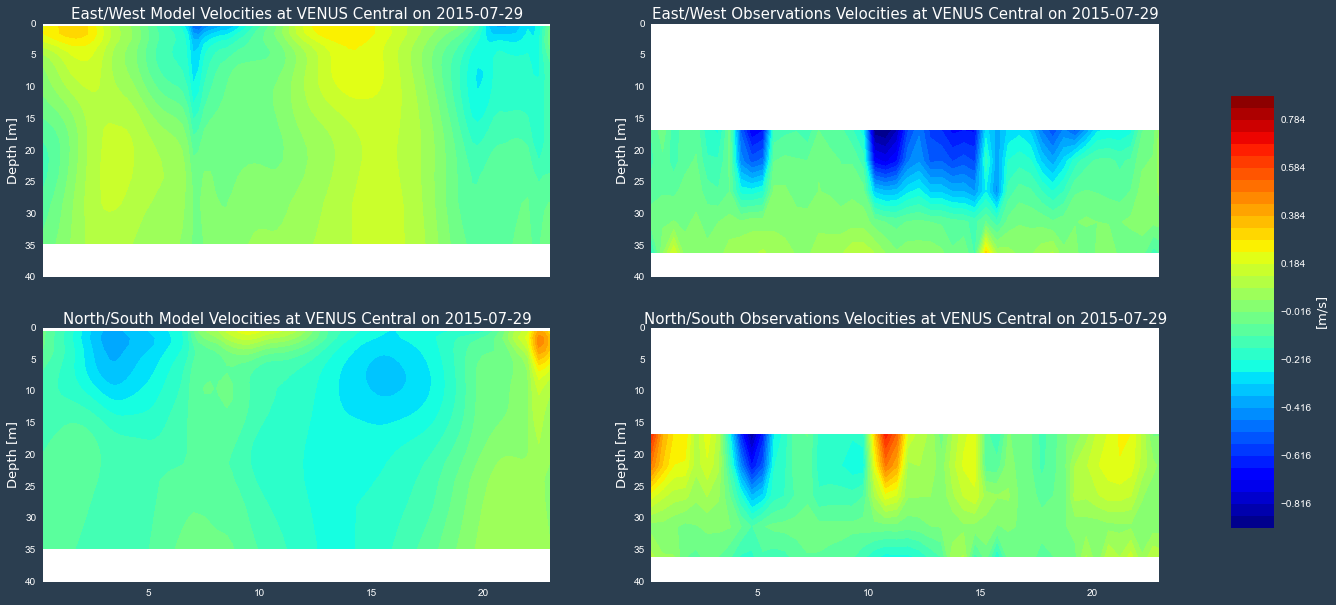

In [6]:
fig1 = plotADCP( yesterday, 'Central', [0,40])

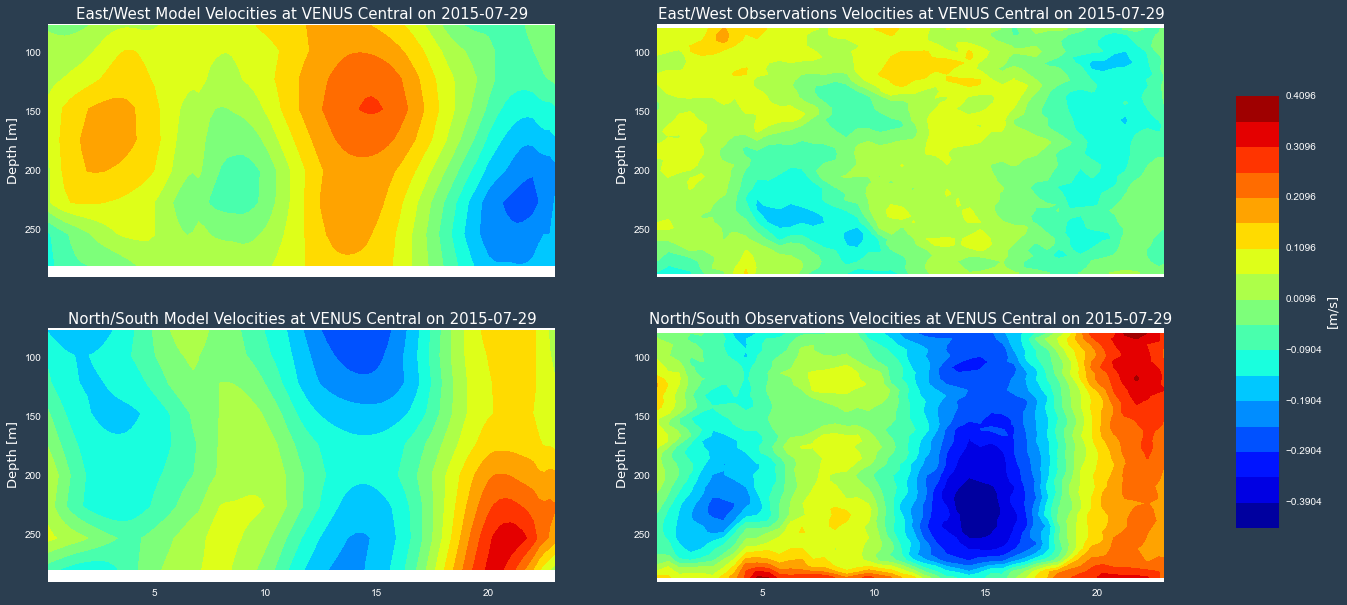

In [7]:
fig1 = plotADCP(yesterday, 'Central', [75,290])

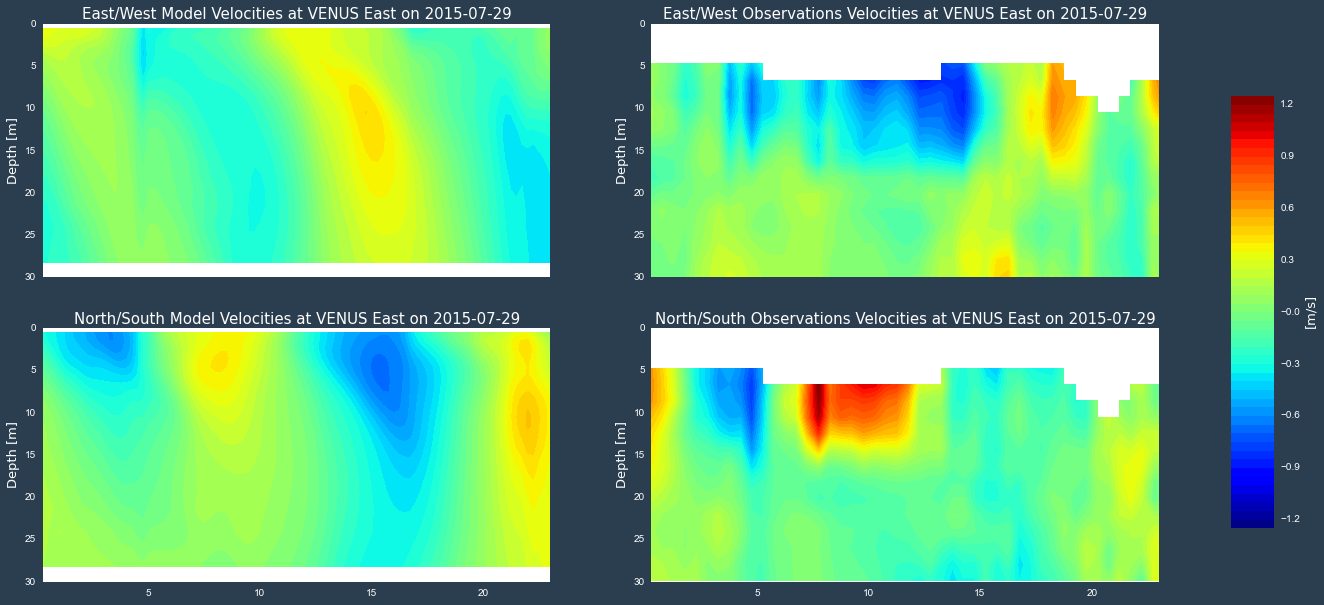

In [8]:
fig1 = plotADCP(yesterday, 'East', [0,30])

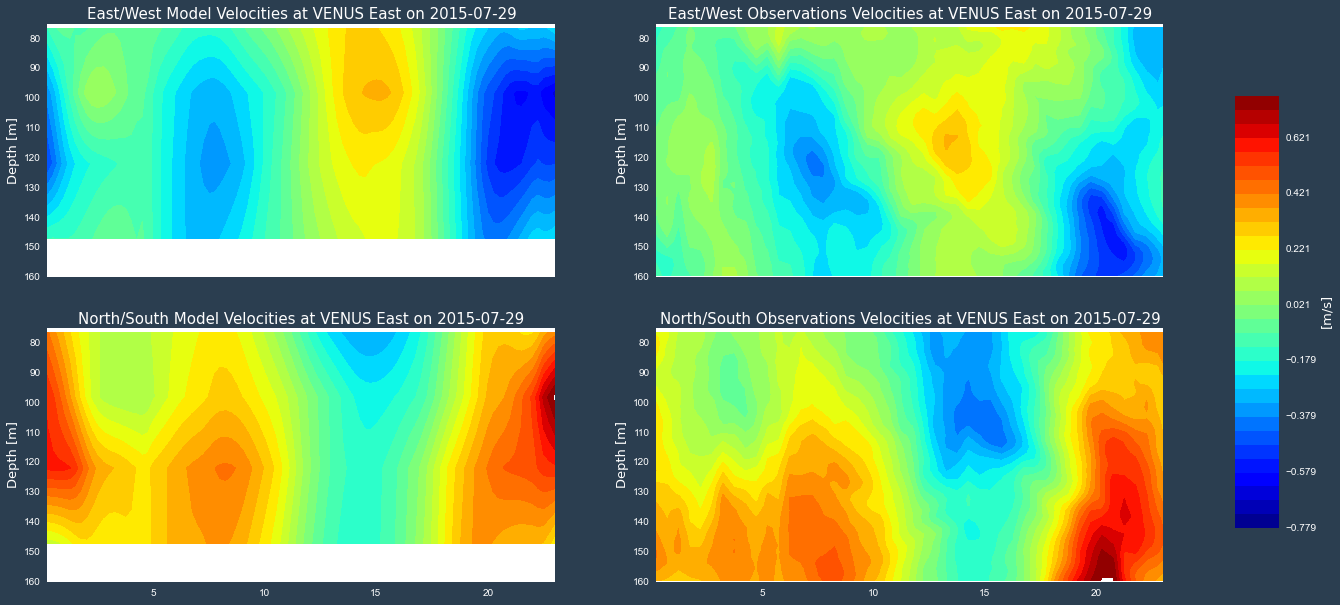

In [9]:
fig1 = plotADCP(yesterday, 'East', [75,160])

In [10]:
def plotdepavADCP(day, station):
    if station =='Central':
        profile = [40, 280]
    else:
        profile = [30, 160]
    
    u_E, v_N, dep_t = load_vel(day, station, 'model', profile)
    u, v, dep = load_vel(day, station, 'observational', profile)

    #Depth averaging center of water column
    uE_av = analyze.depth_average(u_E,dep_t,1)
    vN_av = analyze.depth_average(v_N,dep_t,1)
    u_av = analyze.depth_average(u,dep[::-1],0)
    v_av = analyze.depth_average(v,dep[::-1],0)

    #Begin figure
    fig, ([ax1, ax2]) = plt.subplots(2, 1, figsize=(15,10), sharex=True)
    fig.patch.set_facecolor('#2B3E50')
    
    timestep = 0.5
    velocities = [uE_av, vN_av]
    veloobs = [u_av, v_av]
    axes = [ax1, ax2]
    direction = ['East/West', 'North/South',]
    
    for ax, vel, velo, direc in zip(axes, velocities, veloobs, direction):
        ax.plot(np.arange(0, 24, timestep/2), vel, label = 'Model')
        ax.plot(np.arange(0.25, 24, timestep), velo, label = 'Observations')
        ax.set_xlim([0, 24])
        ax.set_ylabel('Velocity [m/s]', **axis_font)
        figures.axis_colors(ax, 'white')
        ax.set_title('Depth Averaged {dire} velocities at VENUS {node} on {date}'.format(
            dire=direc, node=station, date=day.date()), **title_font)
    ax1.legend(loc=0)

    return fig

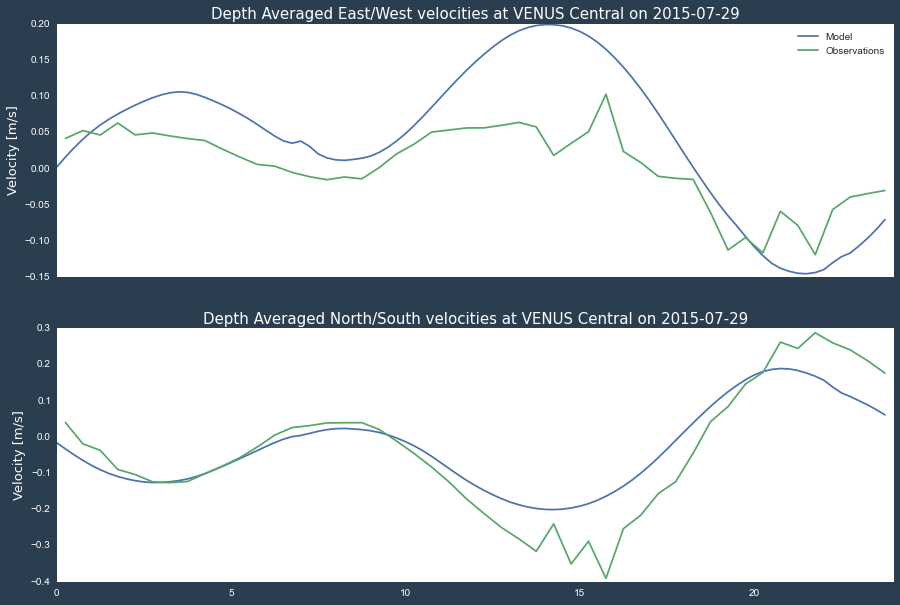

In [11]:
fig = plotdepavADCP(yesterday, 'Central')

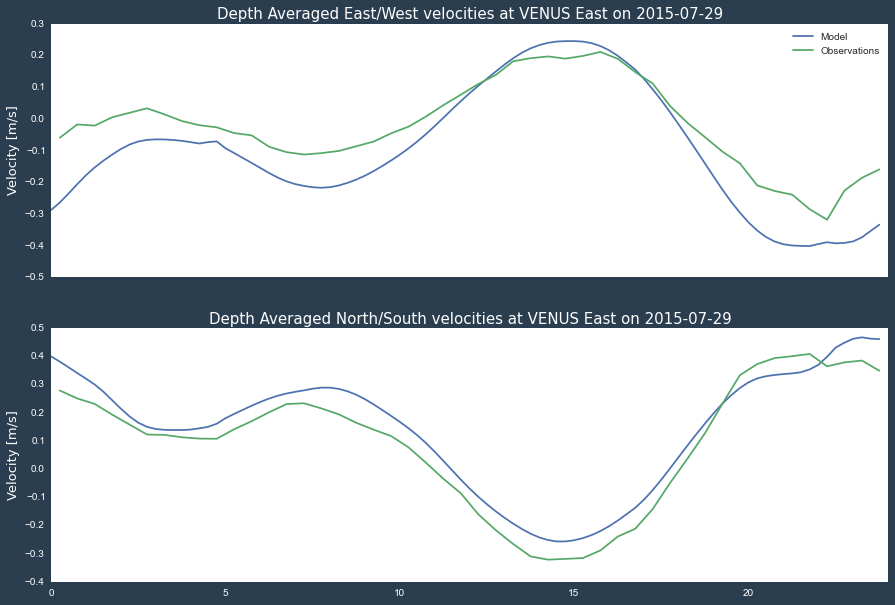

In [12]:
fig = plotdepavADCP(yesterday, 'East')

In [13]:
def plottimeavADCP(day, station):
    
    if station =='Central':
        profile = [0, 290]
    else:
        profile = [0, 170]
    
    u_E, v_N, dep_t = load_vel(day, station, 'model', profile)
    u, v, dep = load_vel(day, station, 'observational', profile)


    #Begin figure
    fig, ([ax1, ax2]) = plt.subplots(1, 2, figsize=(10,10), sharex=True)
    fig.patch.set_facecolor('#2B3E50')
    
    velocities = [u_E, v_N]
    veloobs = [u, v]
    axes = [ax1, ax2]
    direction = ['E/W', 'N/S',]
    
    for ax, vel, velo, direc in zip(axes, velocities, veloobs, direction):
        ax.invert_yaxis()
        ax.plot(np.nanmean(vel, axis=0),dep_t[:],  label = 'Model')
        ax.plot(np.nanmean(velo, axis=1), dep,label = 'Observations')
        ax.set_ylabel('Velocity [m/s]', **axis_font)
        figures.axis_colors(ax, 'white')
        ax.set_title('{dire} velocities at VENUS {node}'.format(
            dire=direc, node=station, date=day.date()), **title_font)
    ax1.legend(loc=0)

    return fig

/home/mdunn/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


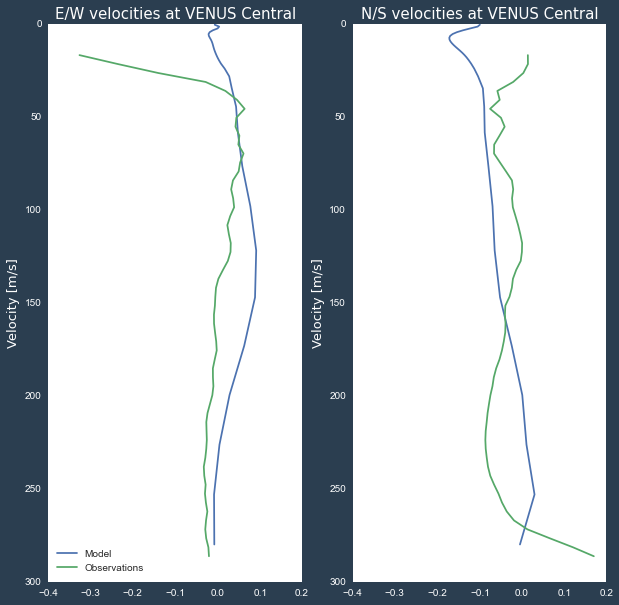

In [14]:
fig = plottimeavADCP(yesterday, 'Central')

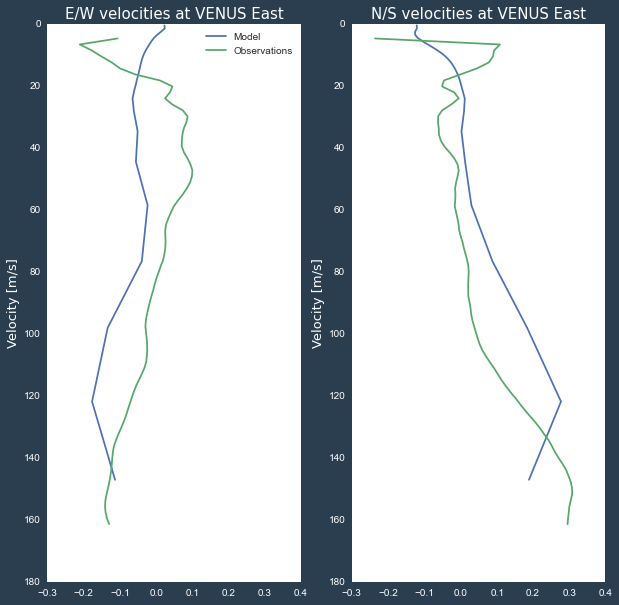

In [15]:
fig = plottimeavADCP(yesterday, 'East')